<a href="https://colab.research.google.com/github/cytoscape/cytoscape-automation/blob/master/for-scripters/Python/affinity-purification-mass-spectrometry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Affinity purification-mass spectrometry network analysis
## Yihang Xin and Alex Pico
## 2021-11-05

This notebook describes how to use data from an affinity purification-mass spectrometry experiment to generate relevant interaction networks, enriching the networks with information from public resources, analyzing the networks and creating effective visualizations.

The result of this vignette will be a visualization of a human-HIV integrated network combining experimental data and publicly available interaction data.

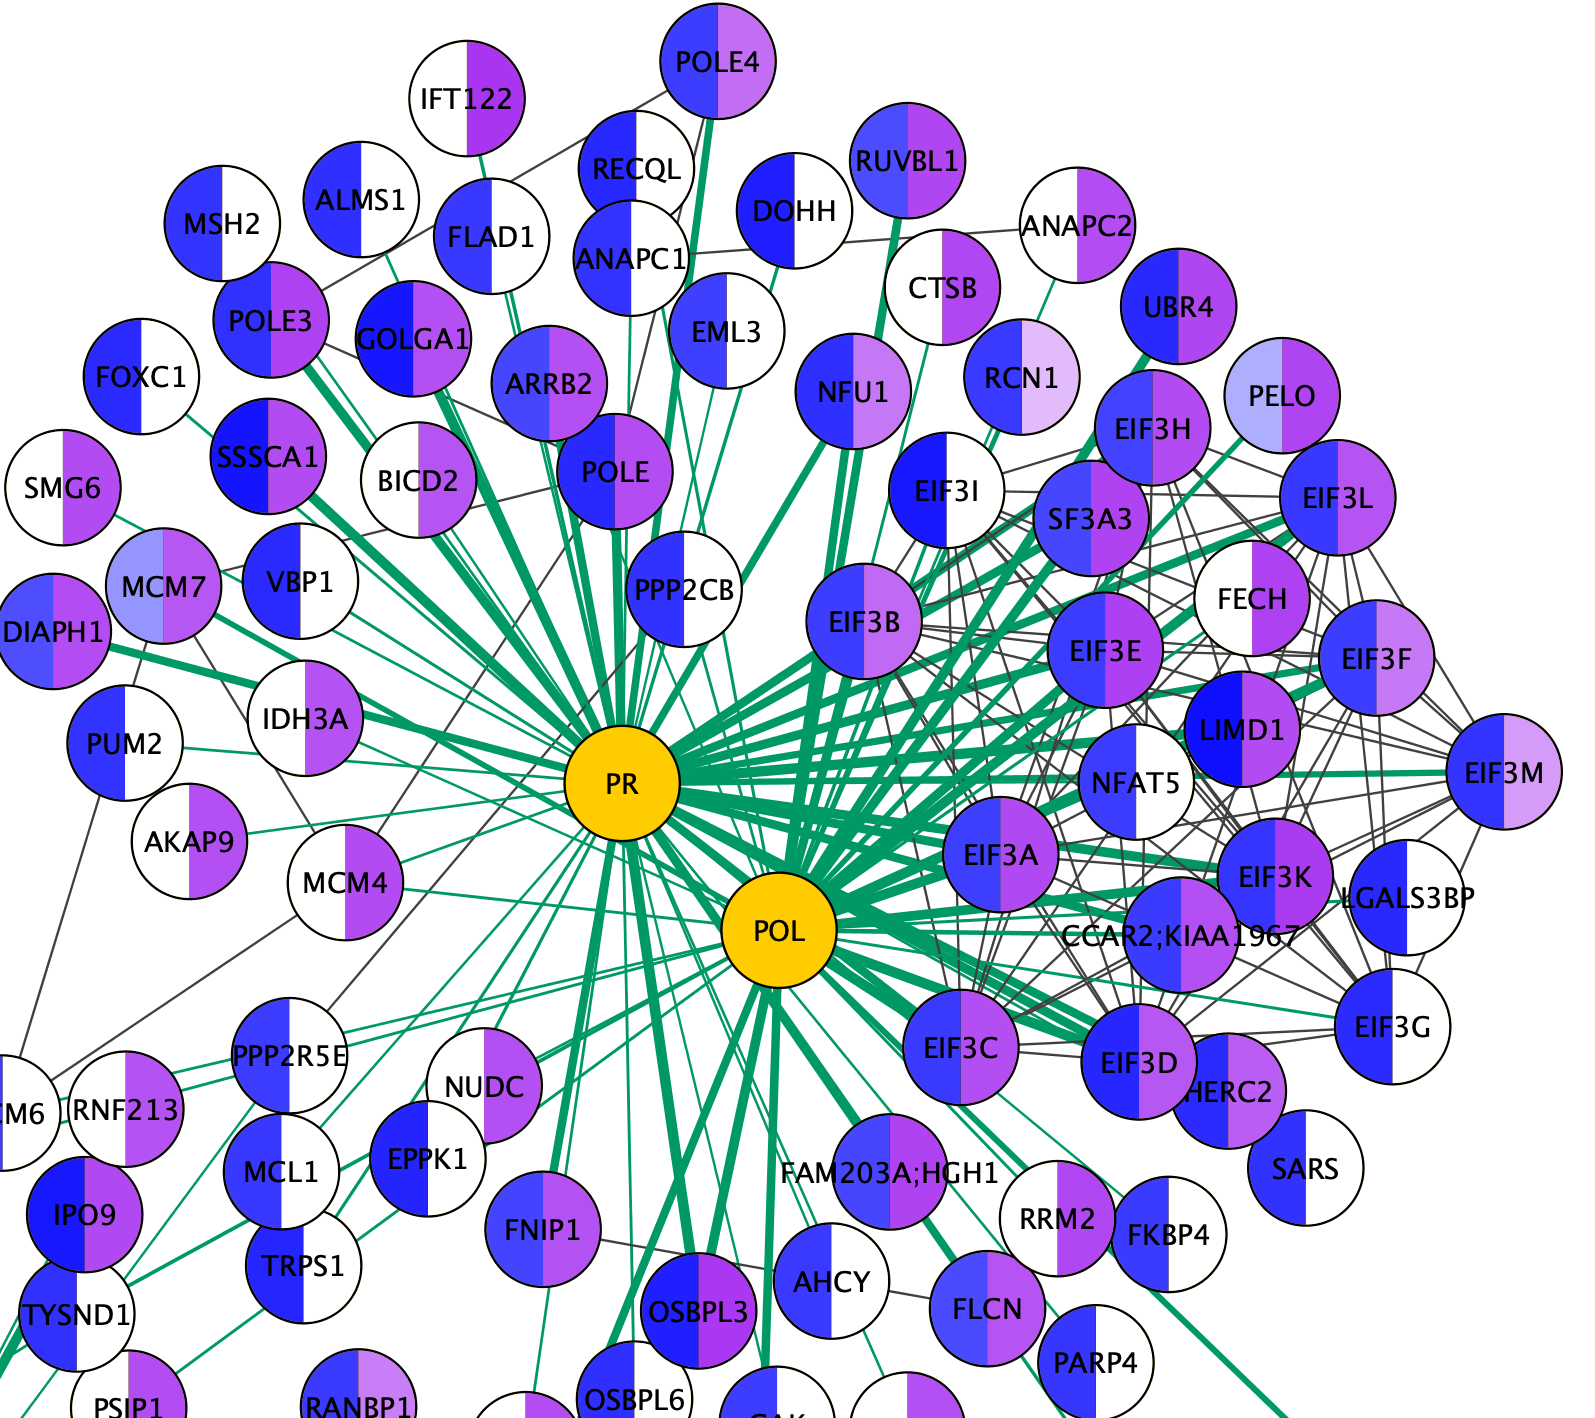

# Installation
The following chunk of code installs the `py4cytoscape` module.

In [ ]:
%%capture
!python3 -m pip install python-igraph requests pandas networkx
!python3 -m pip install py4cytoscape

If you are using a remote notebook environment such as Google Colab, please execute the cell below. (If you're running on your local notebook, you don't need to do that.)



In [ ]:
import requests
exec(requests.get("https://raw.githubusercontent.com/cytoscape/jupyter-bridge/master/client/p4c_init.py").text)
IPython.display.Javascript(_PY4CYTOSCAPE_BROWSER_CLIENT_JS) # Start browser client

You should consider upgrading via the '/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


Loading Javascript client ... 033b8e96-d98b-4ef7-97b5-b96adfbe3ac2 on https://jupyter-bridge.cytoscape.org


<IPython.core.display.Javascript object>

# Prerequisites
In addition to this package (py4cytoscape version 0.0.11), you will need:

* Latest version of Cytoscape, which can be downloaded from https://cytoscape.org/download.html. Simply follow the installation instructions on screen.

* Complete installation wizard

* Launch Cytoscape 

For this notebook, you’ll also need the STRING app and the enhancedGraphics app:

Install the STRING app from https://apps.cytoscape.org/apps/stringapp

Install the enhancedGraphics app from http://apps.cytoscape.org/apps/enhancedgraphics

Install the filetransfer app from https://apps.cytoscape.org/apps/filetransfer

You can also install app inside Python notebook by running "py4cytoscape.install_app('Your App')"

# Background
The data used for this protocol represents interactions between human and HIV proteins by Jäger et al (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3310911/). In this quantitative AP-MS experiment, a relatively small number of bait proteins are used to pull down a larger set of prey proteins.

Note that this tutorial does not describe how to pre-process the raw AP-MS data, the data used here is already scored and filtered.

# Import the required package

In [ ]:
import os
import sys
import pandas as pd
import py4cytoscape as p4c
%matplotlib inline

# Setup Cytoscape

In [ ]:
p4c.cytoscape_version_info()

{'apiVersion': 'v1',
 'cytoscapeVersion': '3.9.0',
 'automationAPIVersion': '1.2.0',
 'py4cytoscapeVersion': '0.0.10'}

# Import Network and Data
Let’s start by reading in the example data file:

In [ ]:
ap_ms_url = 'https://raw.githubusercontent.com/cytoscape/cytoscape-automation/master/for-scripters/R/notebooks/AP-MS/ap-ms-demodata.csv'
ap_ms_df = pd.read_csv(ap_ms_url)
ap_ms_df.head()

,Bait,Prey,UniProt,HEKScore,JurkatScore,AP-MS Score
0,GAG,THRAP3,Q9Y2W1,0.807,0.319,0.563
1,GAG,SEPSECS,Q9HD40,0.814,0.200,0.507
2,GAG,IVNS1ABP,Q9Y6Y0,0.753,0.260,0.506
3,GAG,DDX49,Q9Y6V7,0.824,0.000,0.412
4,GAG,PRMT1,Q99873,0.758,0.037,0.397


Now we can create a data frame for the network edges (interactions) using the imported data. We will add an interaction “AP-MS” to each edge, which will be useful later, and we can also add the AP-MS score from the data as an edge attribute:

In [ ]:
edge_data = {'source':ap_ms_df["Bait"],
             'target':ap_ms_df["Prey"],
             'interaction': "AP-MS",
             'AP-MS Score':ap_ms_df["AP-MS Score"]
            }
edges = pd.DataFrame(data=edge_data, columns=['source', 'target', 'interaction','AP-MS Score'])
edges.head(10)

,source,target,interaction,AP-MS Score
0,GAG,THRAP3,AP-MS,0.563
1,GAG,SEPSECS,AP-MS,0.507
2,GAG,IVNS1ABP,AP-MS,0.506
3,GAG,DDX49,AP-MS,0.412
4,GAG,PRMT1,AP-MS,0.397
5,GAG,OLA1,AP-MS,0.389
6,GAG,EIF2AK2,AP-MS,0.383
7,GAG,RBM17,AP-MS,0.382
8,MA,EPRS,AP-MS,0.874
9,MA,OLA1,AP-MS,0.865


Finally, we use the edge data fram to create the network. Note that we don’t need to define a data frame for nodes, as all nodes in this case are represented in the edge data frame.

In [ ]:
p4c.networks.create_network_from_data_frames(None, edges, title='apms network', collection = "apms collection")

Applying default style...
Applying preferred layout


{'networkSUID': 128173}

# Loading Data
There are three other columns of data and annotations for the “Prey” proteins that we want to load into this network.

In this data, the Prey nodes are repeated for each interactions with a Bait node, so the data contains different values for the same attribute (for example HEKScore), for each Prey node. During import, the last value imported will overwrite prior values and visualizations using this attribute thus only shows the last value.

In [ ]:
p4c.tables.load_table_data(ap_ms_df.iloc[:, 1:5], data_key_column="Prey")

'Success: Data loaded in defaultnode table'

# Augmenting Network with Existing Protein-protein Interaction Data
We are going to use existing protein-protein interaction data to enrich the network, using the STRING database with the human protein nodes as input.

Let’s collect all the UniProt identifiers from the data, and create a text string that we can use to query STRING:

In [ ]:
uniport_str = ','.join(ap_ms_df["UniProt"])

In [ ]:
string_cmd_list = ['string protein query','query="',uniport_str,'"', 'species="Homo sapiens"', 'limit=0', 'cutoff=0.999']

In [ ]:
string_cmd = " ".join(string_cmd_list)

In [ ]:
p4c.commands.commands_run(string_cmd)

["Loaded network 'STRING network' with 434 nodes and 326 edges"]

The resulting network contains known interactions between the human proteins, with an evidence score of 0.999 or greater.

# Merge Networks
To incorprate the new information into our AP-MS network, we need merge the STRING and AP-MS networks. We can use the Uniprot IDs available in both networks as the matching attribute, “Uniprot” in the AP-MS network, and “query term in the String network. We will also specify how to merge the attribute containing the node name (symbol), which is contained in the”name" attribute for the AP-MS network and the “display name” for the String network.

In [ ]:
p4c.tools.merge_networks(["apms network, STRING network"], operation='union', node_keys=["Uniprot,query term"], node_merge_map=[["name","display name","display name", "string"]])

137201

# Network Visualization
When the merged network first loads, it will have the STRING style applied. However, because the HIV nodes are not from STRING, they will be grey. The layout also makes the network hard to interpret. Let’s change the style of the network a bit.

First, let’s set our AP-MS network as the current network:

In [ ]:
p4c.get_network_list()

['union: apms network, STRING network', 'STRING network', 'apms network']

In [ ]:
p4c.networks.set_current_network('union: apms network, STRING network')
p4c.network_views.set_current_view()

{}

Next, we can define our style and apply it to the network:

In [ ]:
style_name = "AP-MS"
p4c.styles.create_visual_style(style_name)
p4c.style_dependencies.lock_node_dimensions(True)
p4c.style_defaults.set_node_size_default(50, style_name=style_name)
p4c.style_defaults.set_node_color_default("#CCCCFF", style_name=style_name)
p4c.style_mappings.set_node_label_mapping('display name', style_name=style_name)
p4c.styles.set_visual_style(style_name=style_name)

style_name not specified, so updating "default" style.


{'message': 'Visual Style applied.'}

In [ ]:
p4c.layouts.layout_network(layout_name='force-directed defaultSpringCoefficient=0.00001 defaultSpringLength=50 defaultNodeMass=4')

{}

# STRING Enrichment
Now that we have a merged network, we can do enrichment analysis on it, using the STRING enrichment tool.

The STRING app has built-in enrichment analysis functionality, which includes enrichment for GO Process, GO Component, GO Function, InterPro, KEGG Pathways, and PFAM.

In [ ]:
p4c.commands.commands_run('string make string network="current"')

["Set network 'union: apms network, STRING network as STRING network"]

In [ ]:
string_cmd_list = ['string retrieve enrichment','allNetSpecies="Homo sapiens"', 'background="genome"','selectedNodesOnly="false"']
string_cmd = " ".join(string_cmd_list)
p4c.commands.commands_run(string_cmd)

['"EnrichmentTable": 143929']

The STRING app includes several options for filtering and displaying the enrichment results. We will filter the results to only show GO Process.

In [ ]:
p4c.commands.commands_run('string filter enrichment categories="GO Process" removeOverlapping="true"')

['']

Next, we will add a split donut chart.

In [ ]:
p4c.commands.commands_run('string show charts')

[]

# Visualizing Results - Jurkat Score
We can create a visualization based on the Jurkat Score, and the different interaction types (AP-MS and STRING):

In [ ]:
style_name = "AP-MS Jurkat Score"
p4c.styles.create_visual_style(style_name)
p4c.styles.set_visual_style(style_name=style_name)
p4c.style_defaults.set_node_color_default("#FFCC00", style_name=style_name)
p4c.style_mappings.set_node_label_mapping('display name', style_name=style_name)
p4c.style_mappings.set_edge_color_mapping("interaction", ["AP-MS"], ["#55AA55"], "d", style_name=style_name)
p4c.style_mappings.set_edge_line_width_mapping('AP-MS Score', table_column_values=[0, 1], widths=[1,5], mapping_type="c", style_name=style_name)

''

Now, we define a color gradient based on the data values in the JurkatScore column:





In [ ]:
p4c.set_node_color_mapping(**p4c.gen_node_color_map('JurkatScore', p4c.palette_color_brewer_s_Purples(), style_name=style_name))

''

We now have a visualization of the network highlighting the ap-ms experimental data (green edges), as well as additional known interactions (grey edges), with node color indicating the Jurkat Score from the data.

# Visualizing Results - Combined
We could create a similar kind of style for the HEK score, but that only allows for viewing each style seperately. Instead, we can create a combined style, using the enhancedGraphics app.

For this, we will need a new column defining a new attribute that will be used for mapping to the Custom Graphics property via the enhancedGraphics app. This new attribute has to be in the form of mappings recognized by the enhancedGraphics app.

We can copy the previous style to retain some of the mappings we want to keep:

In [ ]:
p4c.styles.copy_visual_style("AP-MS Jurkat Score", "AP-MS CombinedScore")
p4c.styles.set_visual_style(style_name="AP-MS CombinedScore")

{'message': 'Visual Style applied.'}

In [ ]:
all_nodes = p4c.networks.get_all_nodes()

To begin adding the new column, we first define a data frame with the new attribute formatted for enhancedGraphics:

In [ ]:
combined_df = pd.DataFrame(all_nodes, columns=['name'])
combined_df["CombinedScore"] = 'piechart: showlabels=false range="0,1" arcstart=90 valuelist=".5,.5" colorlist="up:blue,zero:white,down:white;up:purple,zero:white,down:white" attributelist="HEKScore,JurkatScore"'

Next, we load this dataframe into the Node Table to create and fill a new column:

In [ ]:
p4c.tables.load_table_data(combined_df, data_key_column="name", table_key_column='name',)

'Success: Data loaded in defaultnode table'

We now have a new column, CombinedScore, that we can use for the mapping. This mapping does not come with a custom helper function, se we are going to use two alternative functions to prepare the passthrough mapping property and then update our visual style with the new mapping:

In [ ]:
piechart_map = p4c.style_mappings.map_visual_property('node customgraphics 4','CombinedScore','p')
p4c.style_mappings.update_style_mapping('AP-MS CombinedScore', piechart_map)

''

Remember that when we imported multiple values for a single node attribute, such as the scores for human nodes interacting with more than one HIV nodes, the last value imported will overwrite prior values and the visualization thus only shows the last value. For EIF3A, which interacts with both PR and POL, only the data relevant to the PR interaction is maintained in the Node Table because our source data was sorted alphabetically by Bait.

# Saving, sharing and publishing

Session files save everything. As with most project software, we recommend saving often!

In [ ]:
p4c.session.save_session('AP-MS_session')

{}

# Saving high resolution image files

You can export extremely high resolution images, including vector graphic formats.

In [ ]:
p4c.network_views.export_image('AP-MS_image', type = 'PDF')

{'file': '/Users/yxin/CytoscapeConfiguration/filetransfer/default_sandbox/AP-MS_image.pdf'}